In [1]:
%load_ext autoreload
%autoreload 2

In [102]:
import daft
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import binom

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from game_simulation import CoinGameSimulation
from game_browser import CoinGameBrowser
from simulate_strategy import simulate_strategy

In [ ]:
def get_pgm():
    y = 1 
    pgm = daft.PGM()
    pgm.add_node("p", r"$p$", 0, y, fixed=True, offset=(1, 3))
    pgm.add_node("L", r"$L$", 1, y)
    pgm.add_node("theta", r"$\theta$", 2, y, fixed=True)
    pgm.add_node("H_n", r"$H_n$", 3, y, observed=True)
    pgm.add_edge("p", "L")
    pgm.add_edge("L", "theta")
    pgm.add_edge("theta", "H_n")
    pgm.add_plate([2.5, 0.5, 1, 1], label=r"$n = 1:N$", shift=-0.2)
    return pgm.render()

### Strategy 4: make use of simple Bayesian reasoning.
This strategy use simple Bayeisan resoning to determine the best strategy to play.

The following code shows the probabilitic graphical model for the coin flip distribution.

In [ ]:
get_pgm().set_title("PGM of Coin flip");


- $p$: The parameter of the Bernoulli distribution of L, is the probability of the opponent being fair.
- $L$:  Bernouilli distribution with unkown parameter p. Determines if the opponent is a cheater or not.
- $\theta$: The parameter of the Bernoulli distribution of H.
- $H_{1:N}$: Bernouilli distribution with parameter $\theta$ and $N$ samples. Gives the number of heads.

We use Bayes rule to get:
$$
\begin{align*}
P(L | H_{1:N}) &= \frac{P(H_{1:N} | L) \cdot P(L)}{P(H_{1:N})} \\
               &= \frac{\sum_{\theta=0}^1 P(H_{1:N} | L) \cdot P(L)}{P(H_{1:N})} \\
               &\propto \sum_{\theta=0}^1 P(H_{1:N} | L) \cdot P(L)\\
\end{align*}
$$

We know that:
$$
p = 0.5
$$
$$
\theta=0.5 \text{ if } L=0, \text{ and } \theta=0.75 \text{ if } L=1.
$$
<!--
Meaning that:

 $$
P(\theta | L=0) = 
\begin{cases}
& 1\quad \text{if } \theta=0.5 \\
& 0\quad \text{otherwise} \\
\end{cases} \\

P(\theta | L=1) = 
\begin{cases}
& 1\quad \text{if } \theta=0.75 \\
& 0\quad \text{otherwise} \\
\end{cases} \\

$$ -->

In [140]:
class StrategyBayseian:

    def __init__(self, 
                 threshold = 0.75, 
                 n = 50,
                 flip_5_at_start = False):
        # max value for n is 500
        self.threshold = threshold 
        self.flip_5_at_start = flip_5_at_start

        n_heads_array = np.arange(n).reshape(n, 1)
        n_tails_array = np.arange(n)
        p = np.zeros((n, n, 2))
        p[:, :, 0] = 0.5 ** n_heads_array * 0.5 ** n_tails_array
        p[:, :, 1] = 0.75 ** n_heads_array * (1-0.75) ** n_tails_array
        self.p = p / p.sum(axis=2)[:, :, np.newaxis]

    def set_theshold(self, threshold):
        assert 0 <= threshold <= 1
        self.threshold = threshold

    def show_p(self, shape=None):
        if shape is None:
            shape = self.p.shape
        plt.imshow(self.p[:shape[0], :shape[1], 0])
        plt.show()

    def get_p(self):
        return self.p

    def strategy(self, n_heads, n_tails, flips_left):
        if self.flip_5_at_start and n_heads + n_tails == 0 and flips_left >= 5:
            return 1
        
        p = self.p[n_heads, n_tails, :]

        if np.max(p) > self.threshold or flips_left == 0:
            label = np.argmax(p)
            return label + 2
        else:
            return 0

In [141]:
strat = StrategyBayseian()
g = CoinGameSimulation()
scores = []

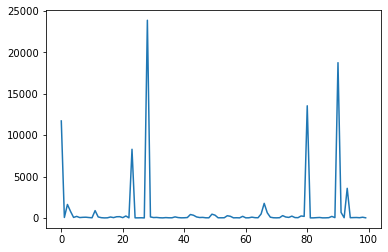

In [126]:
for i in range(100):
    (n_heads, n_tails, flips_left) = g.reset()
    done = False
    while not done:
        action = strat.strategy(n_heads, n_tails, flips_left)
        (n_heads, n_tails, flips_left), reward, done, info = g.step(action)

    score = info["score"]
    scores.append(score)

clear_output(wait=True)
plt.plot(scores, label="scores")
plt.show()

In [144]:
strat.set_theshold(0.78)
simulate_strategy(strat.strategy, n_simulations=500)

In [ ]:
strat.flip_5_at_start = True

In [ ]:
g = CoinGameBrowser()
log_file = "log_strat4.txt"

In [ ]:
n 

In [ ]:
with open(log_file, 'w') as f:
    f.write('Score,Flips left,Heads,Tails,Action,Reward\n')

In [ ]:
for i in range(20):
    (n_heads, n_tails, flips_left) = g.reset()
    done = False
    while not done:
        action = strat.strategy(n_heads, n_tails, flips_left)
        (n_heads, n_tails, flips_left), reward, done, info = g.step(action)
        score = info["score"]
        with open(log_file, 'a') as f:
            f.write(f'{score:3},{flips_left:3},{n_heads:2},{n_tails:2},{action:2},{reward:3}\n')
    if score > 100:
        break

from pygame import mixer, time
mixer.init()
while True:
    sound = mixer.Sound("coin-win-notification.wav")
    sound.play()
    time.wait(int(sound.get_length() * 1000))